# Boston Housing Prices Data Analysis Example

## Boston housing prices
The objective is to analyze the data of median home prics in Boston.  The variables are crime rate, zoning information,
proportion of non-retail business, etc.  This dataset has median prices in Boston for 1972.  Even though the data is pretty old, the methodology for analytics is valid for more recent datasets.

<b>The purpose of this demonstration is to show analytical and transformation capabilities of the Python library </b>

The dataset is from Kaggle. https://www.kaggle.com/c/boston-housing. For tutorials use only.

## Housing Values in Suburbs of Boston in 1972

The <font color='red'>medv</font> variable is the target variable.
### Data description
The Boston data frame has 506 rows and 14 columns.
This data frame contains the following columns:
1. __crim__: per capita crime rate by town.
2. __zn__: proportion of residential land zoned for lots over 25,000 sq.ft.
3. __indus__: proportion of non-retail business acres per town.
4. __chas__: Charles River dummy variable (1 if tract bounds river; 0 otherwise).
5. __nox__: nitrogen oxides concentration (parts per 10 million).
6. __rm__: average number of rooms per dwelling.
7. __age__: proportion of owner-occupied units built prior to 1940.
8. __dis__: weighted mean of distances to five Boston employment centres.
9. __rad__: index of accessibility to radial highways.
10. __tax__: full-value property-tax rate per \$10000
11. __ptratio__: pupil-teacher ratio by town.
12. __black__: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
13. __lstat__: lower status of the population (percent).
14. __medv__: median value of owner-occupied homes in $1000s.
</td></tr></table>

### Factoids
The prices in Boston across years is below.  If we had a historical dataset, an analysis could be done to account for the macro trends as well.

The second graph shows the intuition we have with respect to prices in relation to crime rate.  It is expected that house prices will be lower in areas where crime rates are higher.


<table><tr>
<td><img src="images/boston_prices_by_year.png" alt="Boston home prices" title="Boston housing prices" style="float:left;" /></td>
<td><img src="images/Crime-Rate-and-Median-House-Prices.png" alt="Boston home prices" title="Boston housing prices"  /></td>
</td></tr></table>

In [1]:
from hana_ml import dataframe
from hana_ml.algorithms.pal import clustering
from hana_ml.algorithms.pal import trees
import numpy as np
import matplotlib.pyplot as plt
import logging

## Load data
The data is loaded into 4 tables, for full, training, validation, and test sets:
<li>BOSTON_HOUSING_PRICES</li>
<li>BOSTON_HOUSING_PRICES_TRAINING</li>
<li>BOSTON_HOUSING_PRICES_VALIDATION</li>
<li>BOSTON_HOUSING_PRICES_TEST</li>

To do that, a connection is created and passed to the loader.

There is a config file, config/e2edata.ini that controls the connection parameters and whether or not to reload the data from scratch.  In case the data is already loaded, there would be no need to load the data.  A sample section is below.  If the config parameter, reload_data is true then the tables for test, training, and validation are (re-)created and data inserted into them.

#########################<br>
[hana]<br>
url=host.sjc.sap.corp<br>
user=username<br>
passwd=userpassword<br>
port=3xx15<br>
<br>
[bostonhousingdataset]<br>
reload_data=true
#########################<br>

In [2]:
from data_load_utils import DataSets, Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)
full_tbl, training_tbl, validation_tbl, test_tbl = DataSets.load_boston_housing_data(connection_context)

# Create Data Frames
Create the data frames for the full, test, training, and validation sets.

Let us also do some dtaa exploration.

## Define Datasets - Training, validation, and test sets
Data frames are used keep references to data so computation on large data sets in HANA can happen in HANA.  Trying to bring the entire data set into the client will likely result in out of memory exceptions.

The original/full dataset is split into training, test and validation sets.  In the example below, they reside in different tables.

In [3]:
full_set = connection_context.table(full_tbl)
training_set = connection_context.table(training_tbl)
validation_set = connection_context.table(validation_tbl)
test_set = connection_context.table(test_tbl)
features=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'BLACK', 'LSTAT']
label='MEDV'

# Data Analysis
It is important to look at the dataset and analyze it to gain some insights.

## Simple Exploration
Let us look at the number of rows in the data set.  <b>Note that the dataset is not brought back to the client</b>

In [4]:
print('Number of rows in full set: {}'.format(full_set.count()))
print('Number of rows in training set: {}'.format(training_set.count()))
print('Number of rows in validation set: {}'.format(validation_set.count()))
print('Number of rows in test set: {}'.format(test_set.count()))

Number of rows in full set: 506
Number of rows in training set: 315
Number of rows in validation set: 64
Number of rows in test set: 127


### Let's look at the columns

In [5]:
print(full_set.columns)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'BLACK', 'LSTAT', 'MEDV', 'ID']


### Let's look at the data types

In [6]:
full_set.dtypes()

[('CRIM', 'DECIMAL', 12),
 ('ZN', 'DECIMAL', 7),
 ('INDUS', 'DECIMAL', 7),
 ('CHAS', 'SMALLINT', 5),
 ('NOX', 'DECIMAL', 10),
 ('RM', 'DECIMAL', 8),
 ('AGE', 'DECIMAL', 7),
 ('DIS', 'DECIMAL', 11),
 ('RAD', 'TINYINT', 3),
 ('TAX', 'SMALLINT', 5),
 ('PTRATIO', 'DECIMAL', 6),
 ('BLACK', 'DECIMAL', 9),
 ('LSTAT', 'DECIMAL', 7),
 ('MEDV', 'DECIMAL', 6),
 ('ID', 'INT', 10)]

### Let's see a few rows.
Note that the collect() method brings back the rows to the client and the head() method only chooses the top-k rows.

In [7]:
full_set.head(5).collect()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,BLACK,LSTAT,MEDV,ID
0,0.03306,0,5.19,0,0.515,6.059,37.3,4.8122,5,224,20.2,396.14,8.51,20.6,339
1,0.05497,0,5.19,0,0.515,5.985,45.4,4.8122,5,224,20.2,396.9,9.74,19,340
2,0.06151,0,5.19,0,0.515,5.968,58.5,4.8122,5,224,20.2,396.9,9.29,18.7,341
3,0.01301,35,1.52,0,0.442,7.241,49.3,7.0379,1,284,15.5,394.74,5.49,32.7,342
4,0.02498,0,1.89,0,0.518,6.54,59.7,6.2669,1,422,15.9,389.96,8.65,16.5,343


### Distinct Values
Looks like Zone (ZN) is categorical.  How many zones are there in the data set?

In [8]:
full_set.distinct("ZN").count()

26

### Simple sorting
What are the distinct Zone (ZN) values in sorted order?

In [9]:
full_set.distinct("ZN").sort("ZN", desc=False).collect()

,ZN
0,0
1,12.5
2,17.5
3,18
4,20
5,21
6,22
7,25
8,28
9,30


### Projection and building DataFrames based on other DataFrames
Just select the AGE and MEDV columns.  MEDV is the median price of the home.

Let us just look at the first five rows ordered by AGE.

Below, we create a DataFrame df_age from the DataFrame full_set.  Also, note that df_age.sort() returns a DataFrame and no data is moved to the client.  The head() method also just returns a DataFrame

In [10]:
df_age = full_set.select(["ID", "AGE", "MEDV"])
df_age.head(5).collect()

,ID,AGE,MEDV
0,339,37.3,20.6
1,340,45.4,19
2,341,58.5,18.7
3,342,49.3,32.7
4,343,59.7,16.5


In [11]:
df_age_sorted = df_age.sort("AGE")
df_age_sorted.head(5).collect()

,ID,AGE,MEDV
0,42,2.9,26.6
1,75,6,24.1
2,74,6.2,23.4
3,44,6.5,24.7
4,43,6.6,25.3


### Filtering Data
Fetch rows where the age is greater than 20.  We should get fewer than 500 rows.

In [12]:
df_filtered = full_set.filter('"AGE"<50')
df_filtered.count()

147

In [13]:
# Let's look at a few rows
df_filtered.head(5).collect()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,BLACK,LSTAT,MEDV,ID
0,0.03306,0,5.19,0,0.515,6.059,37.3,4.8122,5,224,20.2,396.14,8.51,20.6,339
1,0.05497,0,5.19,0,0.515,5.985,45.4,4.8122,5,224,20.2,396.9,9.74,19,340
2,0.01301,35,1.52,0,0.442,7.241,49.3,7.0379,1,284,15.5,394.74,5.49,32.7,342
3,0.03049,55,3.78,0,0.484,6.874,28.1,6.4654,5,370,17.6,387.97,4.61,31.2,345
4,0.03113,0,4.39,0,0.442,6.014,48.5,8.0136,3,352,18.8,385.64,10.53,17.5,346


### Joins
Let us get the rows where the age is the same in training and test sets.

In [14]:
df_joined = training_set.alias('TRAIN').join(test_set.alias('TEST'), 'TRAIN.AGE=TEST.AGE')
df_joined.count()  # Note that the training set had 315 rows

150

## More Data Analysis

Some other statistical information to look into:
<li>Are there any null values?</li>

<li>Are there duplicates?</li>

<li>What are the counts, mean, median, modes, standard deviation of columns?</li>

<li>What is the distribution of categorical variables?</li>


Describe all columns and look at some statistics to get a sense of the counts, number of distinct values, number of nulls, etc.

The column "nulls" below contains the number of nulls in a column.

The column "unique" below contains the number of unique values for a column.

The column "std" below is the standard deviation.

In [15]:
full_set.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,CRIM,506,504,0,3.61352,8.60155,0.00632,88.9762,0.25651,0.082045,0.08199,0.25651,0.25387,3.677083,3.67822
1,ZN,506,26,0,11.363,23.322,0,100,0,0.000000,0,0.00000,0,12.500000,12.5
2,INDUS,506,76,0,11.13,6.86,0.46,27.74,9.69,5.190000,5.19,9.69000,9.69,18.100000,18.1
3,NOX,506,81,0,0.5546,0.1159,0.385,0.871,0.538,0.449000,0.449,0.53800,0.538,0.624000,0.624
4,RM,506,446,0,6.284,0.703,3.561,8.78,6.208,5.885500,5.885,6.20850,6.208,6.623500,6.625
5,AGE,506,356,0,68.574,28.149,2.9,100,77.5,45.025000,45,77.50000,77.3,94.075000,94.1
6,DIS,506,412,0,3.795,2.1057,1.1296,12.1265,3.2074,2.100175,2.1,3.20745,3.1992,5.188425,5.2119
7,RAD,506,9,0,9.549407,8.707259,1,24,5,4.000000,4,5.00000,5,24.000000,24
8,PTRATIO,506,46,0,18.45,2.16,12.6,22,19.05,17.400000,17.4,19.05000,19,20.200000,20.2
9,BLACK,506,357,0,356.674,91.295,0.32,396.9,391.44,375.377500,375.33,391.44000,391.43,396.225000,396.23


### Compare to Pandas

Let us compare the same analysis in Pandas.  This is done by bringing the entire dataset to the client.

Note that the results when run directly on HANA is more informative.

In [16]:
pdf = full_set.collect()
pdf.describe(include='all')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,BLACK,LSTAT,MEDV,ID
count,506,506,506,506.000000,506,506,506,506,506.000000,506.000000,506,506,506,506,506.000000
unique,504,26,76,NaN,81,446,356,412,NaN,NaN,46,357,455,229,NaN
top,14.3337,0,18.1,NaN,0.538,6.229,100,3.4952,NaN,NaN,20.2,396.9,6.36,50,NaN
freq,2,372,132,NaN,23,3,43,5,NaN,NaN,140,121,3,16,NaN
mean,NaN,NaN,NaN,0.069170,NaN,NaN,NaN,NaN,9.549407,408.237154,NaN,NaN,NaN,NaN,253.500000
std,NaN,NaN,NaN,0.253994,NaN,NaN,NaN,NaN,8.707259,168.537116,NaN,NaN,NaN,NaN,146.213884
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,187.000000,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,4.000000,279.000000,NaN,NaN,NaN,NaN,127.250000
50%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,5.000000,330.000000,NaN,NaN,NaN,NaN,253.500000
75%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,24.000000,666.000000,NaN,NaN,NaN,NaN,379.750000


#### SQL to generate description above
To give a sense of what SQL a user would have to write to get the description of the data, below is a short snippet of the query generated.  Note that the query is about 80 lines long and a truncated version is shown below.


<font size="-1">SELECT "SimpleStats".*, "Percentiles"."25_percent_cont", "Percentiles"."25_percent_disc", "Percentiles"."50_percent_cont", "Percentiles"."50_percent_disc", "Percentiles"."75_percent_cont", "Percentiles"."75_percent_disc" FROM (select 'CRIM' as "column", COUNT("CRIM") as "count", COUNT(DISTINCT "CRIM") as "unique", SUM(CASE WHEN "CRIM" is NULL THEN 1 ELSE 0 END) as "nulls", AVG("CRIM") as "mean", STDDEV("CRIM") as "std", MIN("CRIM") as "min", MAX("CRIM") as "max", MEDIAN("CRIM") as "median" FROM (SELECT * FROM "BOSTON_HOUSING_PRICES") <b><red>.... 11700 more characters ... </red></b>AS "75_percent_disc" FROM ("SELECT * FROM "BOSTON_HOUSING_PRICES") AS "DT_3"))</font>


### Handle nulls
- Typically, if there are null values, replace nulls with mean, median, or mode depending on use case.  The method to use is fillna().
- Sometimes, nulls are treated specially

The example below substitutes the null values in the AGE column to the average age.  Only one row containing the average age is returned from the database.  All the computation is on the server.

In [17]:
# Get the average
avg_age =  full_set.select(('AVG("AGE")', "AGE")).collect()["AGE"].iloc[0]
# Set the null values to the average.  Note that our dataset does not have nulls.
df_nonulls = full_set.fillna(float(avg_age), ["AGE"])

#### Look at the SQL
The AGE is substituted with the averate that was calculated.

In [18]:
print(df_nonulls.select_statement)

SELECT "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", COALESCE("AGE", 68.574) AS "AGE", "DIS", "RAD", "TAX", "PTRATIO", "BLACK", "LSTAT", "MEDV", "ID" FROM (SELECT * FROM "BOSTON_HOUSING_PRICES") dt


 ### Handle duplicates
 
 If there are duplicates, you may decide to remove them. The method to use is drop_duplicates().
 
 In the example below, duplicates are removed after the nulls have been substituted.  The data frames can be built on top of other data frames.

In [19]:
df_nonulls_no_duplicates = df_nonulls.drop_duplicates()
# No data is returned.  Let us look at the SQL statement generated.
print(df_nonulls_no_duplicates.select_statement)

SELECT DISTINCT * FROM (SELECT "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", COALESCE("AGE", 68.574) AS "AGE", "DIS", "RAD", "TAX", "PTRATIO", "BLACK", "LSTAT", "MEDV", "ID" FROM (SELECT * FROM "BOSTON_HOUSING_PRICES") dt) AS "DT_17"


## Correlations
Let us look at the features that affect the price.
We bring the data from the server to a Pandas dataframe so we can plot the data.  We will do a polynomial fit, specifically a linear fit.

To make the analysis simple, there are some useful functions that are used in this example:
<li>cast():  Casts columns to a specific type and is useful since the PAL libraries require these columns to be of a specific type.</li>
<li>to_head():  Moves a column to the head of the projection list.  PAL assumes that the first column be a unique column in some situations and this function is useful in those cases.</li>
<br>
We show that you can use other libraries for visualization

In [20]:
# Pretty display for notebooks
%matplotlib inline

In [21]:
dfts = full_set.cast(['CRIM', "ZN", "INDUS", "NOX", "RM", "AGE", "DIS", "PTRATIO", "BLACK", "LSTAT", "MEDV"], "DOUBLE")
# Note the cast function
dfts = dfts.cast(["CHAS", "RAD", "TAX"], "INTEGER")
dfts = dfts.to_head("ID")
data = dfts.collect()
prices = data[label]

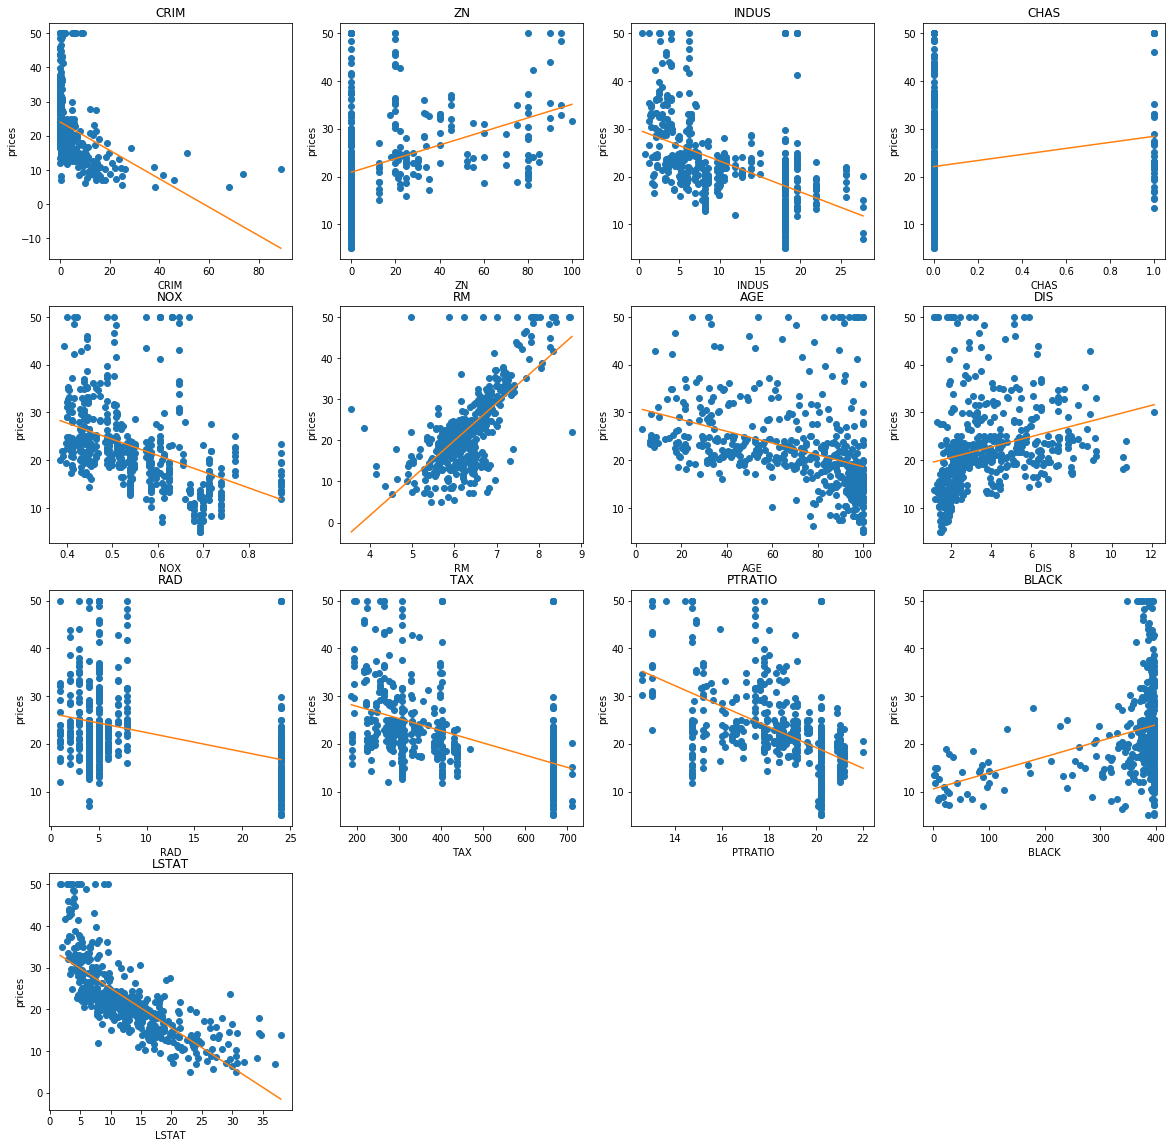

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))

figures_per_line=4
for i, (i, col) in enumerate(zip(range(0,len(features)), features)):
    plt.subplot(len(features)/figures_per_line+1, figures_per_line, i+1)
    plt.subplots_adjust(hspace=0.2)
    x = data[col]
    y = prices
    plt.plot(x, y, 'o')
    # Create a regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')


__What we see above is the LSTAT (lower status of population), RM (number rooms), NOX (pollution), and PTRATIO (pupil teacher ratio) are likely features that impact housing prices the most, at least in 1972!__